# How Pipelines works:

Opracowano na podstawie dokumentacji: https://spark.apache.org/docs/latest/ml-pipeline.html

Pipeline - sekwencja stanów, złożonych z elementów Tranformer lub Estimator.
Elementy te odpalane są według zdefiniowanej kolejności. Przez te elementy przechodzi DataFrame który jest przez nie transformowany. Dla stanów (obiektów) Transformer odpalana jest metoda transform(), dla Estimator odpalana jest metoda fit() aby otrzymać Transformer następnie na tym Transformet jest odpalana metoda transform().
Przykład poniżej:

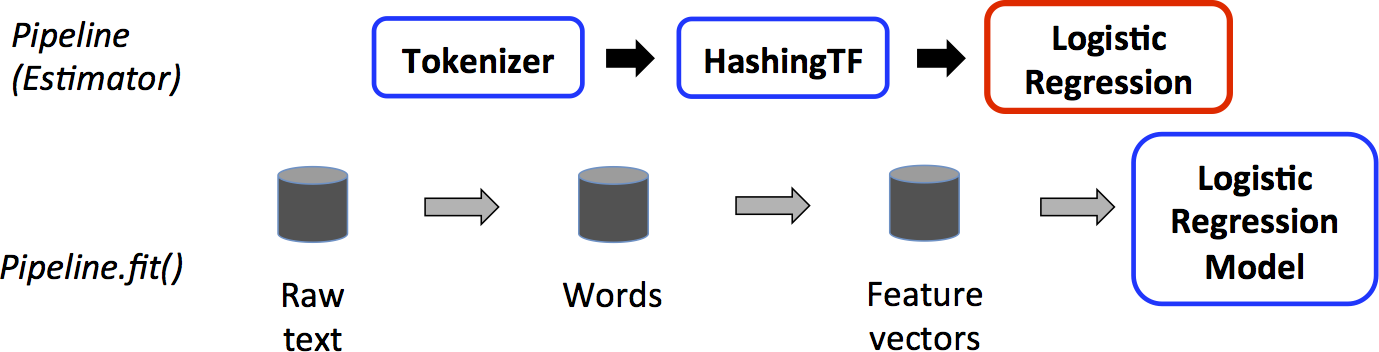

Tokenizer.transform() - zamienia text na słowa
HashingTF.transform() - zamienia słowa na wektory które dodaje do DataFrame
LogisticRegression.fit() - produkuje wyuczony model (LogisticRegressionModel)
LogisticRegressionModel.transform() - zamienia features'y z DataFrame na predykcje

Pipeline jest obiektem typu Estimator
Pipeline.fit() produkuje model PipelineModel który jest Transformer'em. Jest on używany do testów jak pokazuje rysunek poniżej:

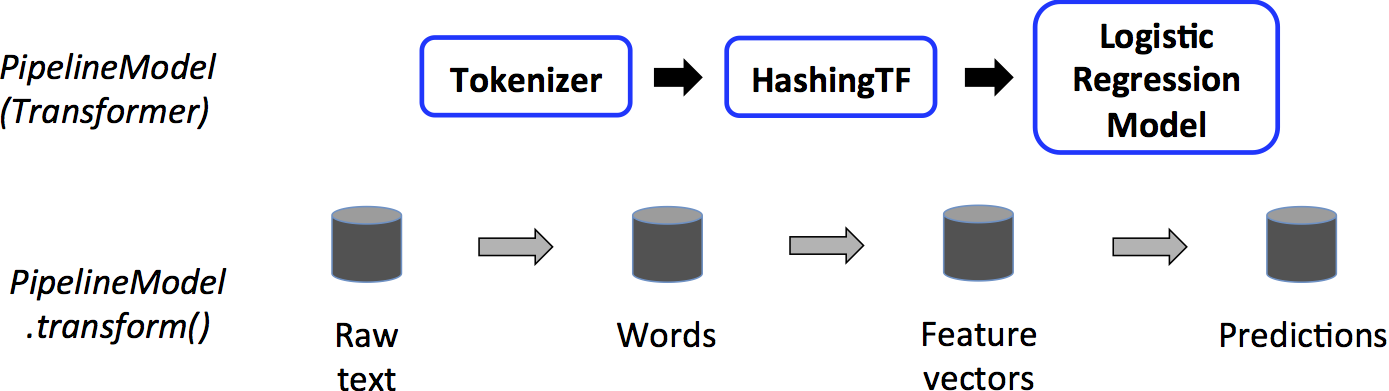

PipelineModel ma tę samą liczbę kroków co Pipeline, ale wszystkie obiekty Estimator są zastąpione przez Transformer'y.
Kiedy wywołamy PipelineModel.transform() na testowym zbiorze danych wywoływane są te same kroki co wcześniej na zbiorze uczącym. Każda wywołana metoda transform() przetwarza zbiór danych i przesyła go do następnego stanu.

Piepeline i PipelineModel pomagają zagwarantować, że zbiory treningowy i testowy przejdą przez identyczny proces przygotowania danych (przez feature processing)

In [2]:
#Przykład:

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext('local')
spark = SparkSession(sc)

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

(4, spark i j k) --> prob=[0.155543713844,0.844456286156], prediction=1.000000
(5, l m n) --> prob=[0.830707735211,0.169292264789], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.0696218406195,0.93037815938], prediction=1.000000
(7, apache hadoop) --> prob=[0.981518350351,0.018481649649], prediction=0.000000
